# TODO
* load full Model and identify significant voxels
* within each combination, calculate overlap of features and calculate unique variance

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
from surfplot import Plot
from matplotlib import colors



In [2]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

In [3]:
def fsaverage_to_fslr_and_plot(Lfname, Rfname, key, cmap='inferno', min=0, max=.05):#,min=-40, max=40):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    giiL = nib.load(Lfname)
    giiR = nib.load(Rfname)
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')
    
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    # color_range = (min,max)
    color_range = (min,max)
    p = Plot(surf_lh=lh_fslr, 
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.5)
    p.add_layer({'left': L_fslr[0], 
                'right': R_fslr[0]}, 
                cmap=cmap, cbar=True,
                color_range=color_range,
                cbar_label=key
                ) # YlOrRd_r
    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    # fig.show()
    return(fig)

def fisher_mean(correlation, axis=None):
    return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))

# A. full model performance


In [31]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'

output_dir = os.path.join(main_dir, 'results', 'himalaya', "glove", 'ha_common_pca-40')
alignment = 'ha_common'
results = [ 'comb-r']#'bg-r', 'agents-r','actions-r',  'moten-r'
runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
pca_comp = 40
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']


save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
hemilabels = ['lh', 'rh']
hemis = ['lh', 'rh']
for result in results:
    hemi_t = []
    hemi_p = []
    hemi_mean = []
    print(f"starting {result} ________________")
    for hemisphere in hemis:
        stats = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/{result}_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        t, p = scipy.stats.ttest_1samp(fisherz_all, popmean=0,axis=0, alternative='greater')
        hemi_t.append(t)
        hemi_p.append(p)
        # hemi_mean.append(np.tanh(np.nanmean(fisherz_all, axis = 0)))

        hemi_mean.append(fisher_mean(fisherz_all, axis=0))
        # fisherz_all_mean = fisher_mean(fisherz_all, axis=0)
        # print(fisherz_all_mean.shape)

        # medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        # assert np.sum(medial_mask) == n_medial[hemisphere]
        # cortical_vertices = ~medial_mask 
        # cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        # stats[cortical_coords] = fisher_mean(fisherz_all, axis=0) #hemi_mean[h] #BUG
        # save_fname = f"{save_dir}/full-r_acagbgmo_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        # write_gifti_v2(stats.astype(np.float32),
        # template_fn = os.path.join(suma_dir, f"{hemis[h]}.pial.gii"), 
        # output_fn = save_fname)
        # print("* saved output (thresholded average r) for both hemispheres")
    # %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
    left_vert = hemi_p[0].shape[0]
    t_all = np.hstack(hemi_t)
    p_all = np.hstack(hemi_p)

    reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
    q_both = [q_all[:left_vert], q_all[left_vert:]]
    print("* completed t-tests for both hemispheres")

    Path(join(output_dir, 'stats')).mkdir(parents = True, exist_ok = True)
    for h, hemisphere in enumerate(hemis):
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials

        stats = np.zeros((n_vertices))
        means = np.zeros((n_vertices))
        means[cortical_coords] = hemi_mean[h]
        
        hemi_mean[h][q_both[h] >= .05] = 0
        stats[cortical_coords] = hemi_mean[h]
        # save_fname = f"{output_dir}/stats/{result}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        # write_gifti_v2(stats.astype(np.float32),
        # template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        # output_fn = save_fname)

        save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
        write_gifti_v2(stats.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = save_fname)

        mean_save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
        output_fn = mean_save_fname)
    print("* saved output (thresholded average r) for both hemispheres")


starting comb-r ________________
* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


# Plot fslr

In [32]:
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
import numpy as np
from surfplot import Plot
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import join
import nibabel as nib
surfaces = fetch_fsaverage()
lh, rh = surfaces['inflated']
main_dir = '/Volumes/life-encoding'
gii_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition' #join(output_dir, 'stats')
print(gii_dir)
alignment = 'ha_common'

/Volumes/life-encoding/results/himalaya/glove_variancepartition


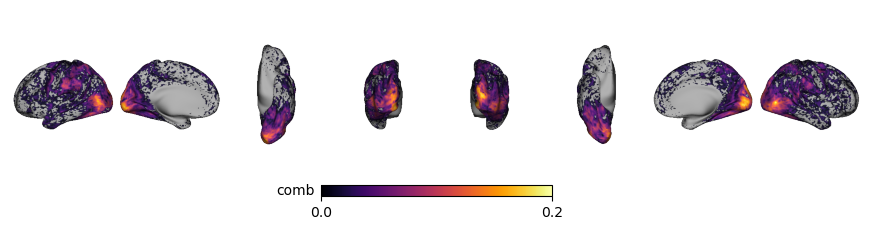

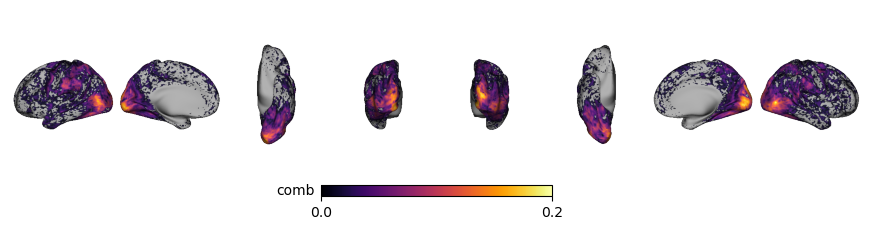

In [33]:
alignment = 'ha_common'

feature = 'comb'
bgLfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-lh_ttest.gii"
bgRfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-rh_ttest.gii"
fsaverage_to_fslr_and_plot(bgLfname, bgRfname, feature, cmap='inferno', max=.2)

## number of significant voxels

In [34]:
alignment = 'ha_common'

Lfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-lh_ttest.gii"
Rfname = f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-rh_ttest.gii"
# fsaverage_to_fslr_and_plot(bgLfname, bgRfname, feature, cmap='inferno', max=.2)

giiL = nib.load(Lfname)
giiR = nib.load(Rfname)

sig_voxel = np.sum(giiL.agg_data() > 0) + np.sum(giiR.agg_data() > 0) 
print(f"{feature}: {sig_voxel}")


comb: 43674


## workbench cluster threshold

In [12]:
from subprocess import call
# parameteres
hemis = ['lh', 'rh']
features = 'comb'
clustersize = 100
hemi_dict = {'lh': 'L', 'rh': 'R'}
fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
# data_dir = os.path.join(output_dir, 'stats') #'/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats'

# thresholding via workbench
for hemi in hemis:
    fsaverage_template = f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_inflated.surf.gii"
    himalaya = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
    outputfname = f"{gii_dir}/full-r_acagbgmo_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
    return_code = call(f"wb_command -metric-find-clusters {fsaverage_template} {himalaya} 0 {clustersize} {outputfname}", shell=True)
print(f"Return: {return_code}")

Return: 0


## check cluster threshold maps

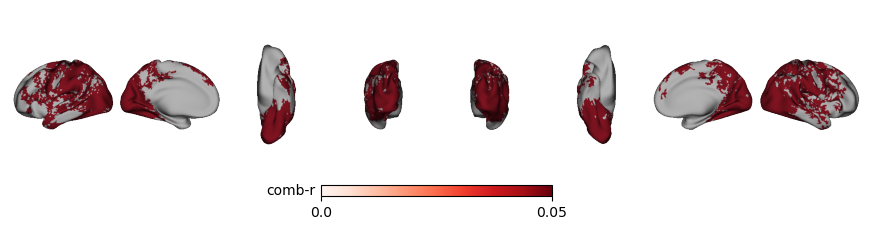

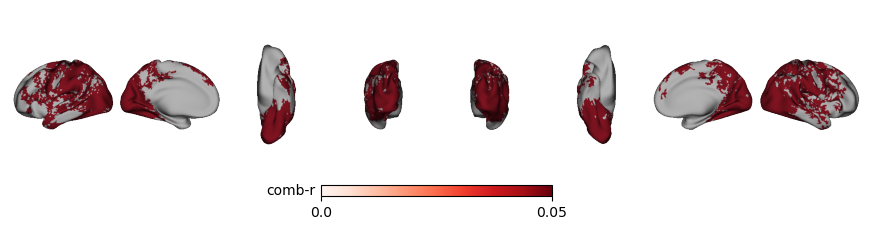

In [13]:
clusterthresL = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-lh_ttest_cluster-{clustersize}.gii"
clusterthresR = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-rh_ttest_cluster-{clustersize}.gii"
fsaverage_to_fslr_and_plot(clusterthresL, clusterthresR, f'{feature}-r', cmap = 'Reds')

In [14]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

hemis = ['lh', 'rh']
hemi_dict = {'lh': 'L', 'rh': 'R'}

fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
# data_dir = '/Volumes/life-encoding/results/himalaya/glove/ha_common_pca-40/stats'

# thresholding via workbench
for hemi in hemis:
    clustermask_fname = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
    clustL = nib.load(clustermask_fname).agg_data() > 0
    himalaya_fname = f"{gii_dir}/{feature}-r_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
    himalaya = nib.load(himalaya_fname).agg_data()
    maskeddata = clustL * himalaya
    write_gifti_v2(maskeddata.astype(np.float32), 
        output_fn=f"{gii_dir}/{feature}-r_pca-40_align-{alignment}_hemi-{hemi}_ttest_thres-cluster{clustersize}.gii",
        template_fn=f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_pial.surf.gii")

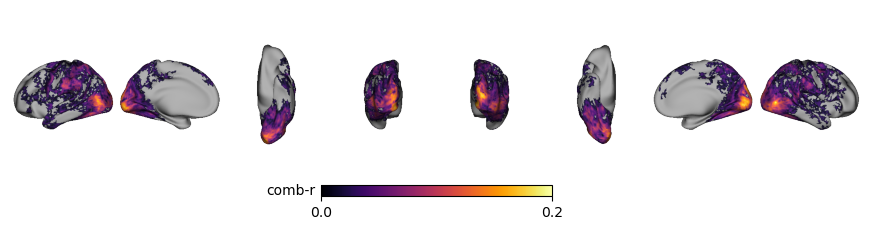

In [15]:
save_dir = f'/Users/h/Documents/projects_local/life-encoding/figure/glove/{feature}/variancepart'
save_dir = f'/Users/h/jung2heejung@gmail.com - Google Drive/My Drive/life_encoding/figure/variancepart'

r_type = 'r'
Path(save_dir).mkdir(exist_ok=True, parents=True)
thresL = f"{gii_dir}/comb-{r_type}_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.gii"
thresR = f"{gii_dir}/comb-{r_type}_pca-40_align-{alignment}_hemi-rh_ttest_thres-cluster{clustersize}.gii"
fig = fsaverage_to_fslr_and_plot(thresL, thresR, f'{feature}-r', cmap='inferno',min=0, max=.2)
fig.savefig(join(save_dir, f"{features}-r_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.png"), dpi=300)

# prototype
actions_agents_intersect = actions_single + agents_single - agents_actions_nested
actions_bg_intersect = actions_single + bg_single - actions_bg_nested
agents_bg_intersect = agents_single + bg_single - agents_bg_nested

# B. nested 

In [96]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
# features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")

feature_dict = {'agents-bg-moten': '3agbgmo', 
                'actions-bg-moten': '3acbgmo', 
                'actions-agents-moten': '3acagmo', 
                'actions-agents-bg': '3acagbg', 
                'actions-bg': '2acbg', 
                'agents-bg': '2agbg', 
                'actions-agents': '2acag',
                'actions': '1ac', 
                'agents': '1ag', 
                'bg': '1bg', 
                'moten': '1mo'}

for feature_string in ['actions-bg-moten', 'actions-agents-moten', 'agents-bg-moten',
                       'actions-agents-bg', 'actions-bg', 'agents-bg', 'actions-agents',
                        'actions', 'agents', 'bg', 'moten']:

    output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', feature_string, 'ha_common_pca-40')
    # output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting actions-bg-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents-bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions-agents ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting actions _______________

In [97]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
# features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")

feature_dict = {'agents-bg-moten': '3agbgmo', 
                'actions-bg-moten': '3acbgmo', 
                'actions-agents-moten': '3acagmo', 
                'actions-agents-bg': '3acagbg', 
                'actions-bg': '2acbg', 
                'agents-bg': '2agbg', 
                'actions-agents': '2acag',
                'actions': '1ac', 
                'agents': '1ag', 
                'bg': '1bg', 
                'moten': '1mo'}

for feature_string in [ 'agents-bg-moten']:

    output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', feature_string, 'ha_common_pca-40')
    # output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting agents-bg-moten ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres


# C. 2 feature model

In [89]:
save_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
main_dir = '/Volumes/life-encoding'
r_type = 'r'
hemis = ['lh', 'rh']
features_dir = os.path.join(main_dir, 'results', 'himalaya', "glove_single")
feature_dict = {'actions': '2acmo',
                'agents': '2agmo', 
                'bg': '2bgmo'}
for feature_string in [ 'actions', 'agents', 'bg']: 
    output_dir = os.path.join(features_dir, feature_string + '-moten', 'ha_common_pca-40')
    print(f"starting {feature_string} ________________")
    for h, hemisphere in enumerate(hemis):
        means = np.zeros((n_vertices))
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        avg_all = []
        # NOTE 1. Fisher z transform per run per participant (np.arctanh)
        for test_subject in subjects:
            stack_fisherz_run = []
            for test_run in runs:           

                run_data = np.load(f"{output_dir}/comb-r_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
                fisherz_run = np.arctanh(run_data[0, cortical_vertices])
                stack_fisherz_run.append(fisherz_run)
        
            # NOTE: 2. average (z-transformed) correlations across runs: yields 18 maps (1 per subject)
            avg_run = np.mean(np.vstack(stack_fisherz_run), axis = 0)
            avg_all.append(avg_run)
        fisherz_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

        # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
        medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
        assert np.sum(medial_mask) == n_medial[hemisphere]
        cortical_vertices = ~medial_mask 
        cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
        means[cortical_coords] = fisher_mean(fisherz_all, axis=0)
        save_fname = f"{save_dir}/nested-{r_type}_{feature_dict[feature_string]}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_groupmean.gii"
        write_gifti_v2(means.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"{hemisphere}.pial.gii"), 
        output_fn = save_fname)
        print("* saved output (thresholded average r) for both hemispheres")



starting actions ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting agents ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres
starting bg ________________
* saved output (thresholded average r) for both hemispheres
* saved output (thresholded average r) for both hemispheres


In [46]:
len(cortical_coords)

37471

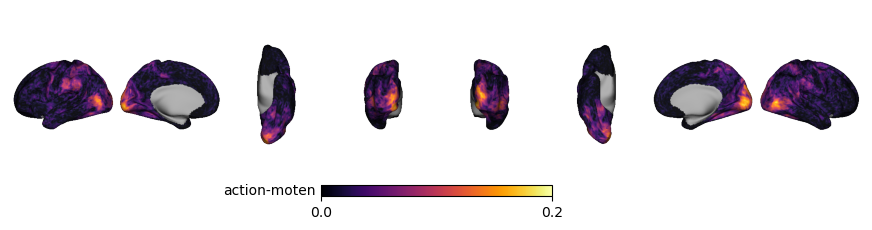

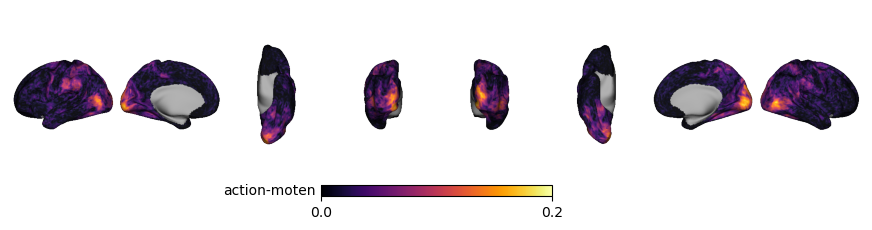

In [51]:
meanimg_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'
feature = 'action-moten'
# three combinations
#3acagbg
f3_acagbg_L_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_acagbg_R_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
# f3_acagbg_L = nib.load(f3_acagbg_L_fname)
# f3_acagbg_R = nib.load(f3_acagbg_R_fname)
fsaverage_to_fslr_and_plot(f3_acagbg_L_fname, f3_acagbg_R_fname, feature, cmap='inferno', max=.2)

In [31]:
cortical_coords.shape

(37476,)

# variance partitioning

In [113]:
meanimg_dir = '/Volumes/life-encoding/results/himalaya/glove_variancepartition'

#4acagbg
f4_acagbgmo_L_fname = join(meanimg_dir,'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f4_acagbgmo_R_fname = join(meanimg_dir,'full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f4_comb_L = nib.load(f4_acagbgmo_L_fname).agg_data()
f4_comb_R = nib.load(f4_acagbgmo_R_fname).agg_data()

maskL = nib.load(join(meanimg_dir, 'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest.gii')).agg_data().astype('bool')
maskR = nib.load(join(meanimg_dir, 'full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest.gii')).agg_data().astype('bool')

In [115]:
fsaverage_to_fslr_and_plot(f4_acagbgmo_L_fname, f4_acagbgmo_R_fname, cmap='Reds')

TypeError: fsaverage_to_fslr_and_plot() missing 1 required positional argument: 'key'

In [6]:

# three combinations
#3acagbg
f3_acagbg_L_fname = join(meanimg_dir,'nested-r_3acagbg_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_acagbg_R_fname = join(meanimg_dir,'nested-r_3acagbg_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f3_acagbg_L = nib.load(f3_acagbg_L_fname).agg_data()
f3_acagbg_R = nib.load(f3_acagbg_R_fname).agg_data()

# 3acagmo
f3_acagmo_L_fname = join(meanimg_dir,'nested-r_3acagmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_acagmo_R_fname = join(meanimg_dir,'nested-r_3acagmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f3_acagmo_L = nib.load(f3_acagmo_L_fname).agg_data()
f3_acagmo_R = nib.load(f3_acagmo_R_fname).agg_data()

# 3acbgmo
f3_acbgmo_L_fname = join(meanimg_dir,'nested-r_3acbgmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_acbgmo_R_fname = join(meanimg_dir,'nested-r_3acbgmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f3_acbgmo_L = nib.load(f3_acbgmo_L_fname).agg_data()
f3_acbgmo_R = nib.load(f3_acbgmo_R_fname).agg_data()

# 3agbgmo
f3_agbgmo_L_fname = join(meanimg_dir,'nested-r_3agbgmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f3_agbgmo_R_fname = join(meanimg_dir,'nested-r_3agbgmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f3_agbgmo_L = nib.load(f3_agbgmo_L_fname).agg_data()
f3_agbgmo_R = nib.load(f3_agbgmo_R_fname).agg_data()

# two combinations
# 2acag
f2_acag_L_fname = join(meanimg_dir,'nested-r_2acag_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_acag_R_fname = join(meanimg_dir,'nested-r_2acag_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_acag_L = nib.load(f2_acag_L_fname).agg_data()
f2_acag_R = nib.load(f2_acag_R_fname).agg_data()
# 2acbg
f2_acbg_L_fname = join(meanimg_dir,'nested-r_2acbg_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_acbg_R_fname = join(meanimg_dir,'nested-r_2acbg_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_acbg_L = nib.load(f2_acbg_L_fname).agg_data()
f2_acbg_R = nib.load(f2_acbg_R_fname).agg_data()
# 2agbg
f2_agbg_L_fname = join(meanimg_dir,'nested-r_2agbg_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_agbg_R_fname = join(meanimg_dir,'nested-r_2agbg_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_agbg_L = nib.load(f2_agbg_L_fname).agg_data()
f2_agbg_R = nib.load(f2_agbg_R_fname).agg_data()
# 2bgmo
f2_bgmo_L_fname = join(meanimg_dir,'nested-r_2bgmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_bgmo_R_fname = join(meanimg_dir,'nested-r_2bgmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_bgmo_L = nib.load(f2_bgmo_L_fname).agg_data()
f2_bgmo_R = nib.load(f2_bgmo_R_fname).agg_data()
# 2acmo
f2_acmo_L_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_acmo_R_fname = join(meanimg_dir,'nested-r_2acmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_acmo_L = nib.load(f2_acmo_L_fname).agg_data()
f2_acmo_R = nib.load(f2_acmo_R_fname).agg_data()
# 2agmo
f2_agmo_L_fname = join(meanimg_dir,'nested-r_2agmo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f2_agmo_R_fname = join(meanimg_dir,'nested-r_2agmo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f2_agmo_L = nib.load(f2_agmo_L_fname).agg_data()
f2_agmo_R = nib.load(f2_agmo_R_fname).agg_data()

# 1ac
f1_ac_L_fname = join(meanimg_dir,'nested-r_1ac_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f1_ac_R_fname = join(meanimg_dir,'nested-r_1ac_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f1_ac_L = nib.load(f1_ac_L_fname).agg_data()
f1_ac_R = nib.load(f1_ac_R_fname).agg_data()
# 1ag
f1_ag_L_fname = join(meanimg_dir,'nested-r_1ag_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f1_ag_R_fname = join(meanimg_dir,'nested-r_1ag_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f1_ag_L = nib.load(f1_ag_L_fname).agg_data()
f1_ag_R = nib.load(f1_ag_R_fname).agg_data()
# 1bg
f1_bg_L_fname = join(meanimg_dir,'nested-r_1bg_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f1_bg_R_fname = join(meanimg_dir,'nested-r_1bg_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f1_bg_L = nib.load(f1_bg_L_fname).agg_data()
f1_bg_R = nib.load(f1_bg_R_fname).agg_data()
# 1mo
f1_mo_L_fname = join(meanimg_dir,'nested-r_1mo_pca-40_align-ha_common_hemi-lh_groupmean.gii')
f1_mo_R_fname = join(meanimg_dir,'nested-r_1mo_pca-40_align-ha_common_hemi-rh_groupmean.gii')
f1_mo_L = nib.load(f1_mo_L_fname).agg_data()
f1_mo_R = nib.load(f1_mo_R_fname).agg_data()

In [11]:
f1_mo_R.shape

(40962,)

In [8]:
# 12 = -24 + 134 + 234 - 1234
# 13 = -24 + 124 + 234 - 1234
# 14 = -23 + 123 + 234 - 1234
# 23 = -14 + 124 + 134 - 1234
# 24 = -13 + 123 - 134 - 1234
# 34 = -12 +123 + 124 - 1234
# 123 = -4 + 14 + 24 + 34 - 124 - 134 - 234 +1234
# 124 = -3 +13 + 23 + 34 -123 -134 -234 + 1234
# 134 = -2 + 12 + 23 + 24 - 123 - 124 - 234 + 1234
# 234 = -1 + 12 + 13 - 14 -123 -124 -134 + 1234
# 1234 = 1 + 2 + 3 + 4 -12 -13 -14 -23 -24 -34 + 123 + 124 + 134 + 234 - 1234

# acag = -agmo + acbgmo + agbgmo - acagbgmo
# acbg = -agmo + acagmo + agbgmo - acagbgmo
# acmo = -agbg + acagbg + agbgmo - acagbgmo
# agbg = -acmo + acagmo + acbgmo - acagbgmo
# agmo = -acbg + acagbg - acbgmo - acagbgmo
# bgmo = -acag +acagbg + acagmo - acagbgmo
# acagbg = -mo + acmo + agmo + bgmo - acagmo - acbgmo - agbgmo +acagbgmo
# acagmo = -bg +acbg + agbg + bgmo -acagbg -acbgmo -agbgmo + acagbgmo
# acbgmo = -ag + acag + agbg + agmo - acagbg - acagmo - agbgmo + acagbgmo
# agbgmo = -ac + acag + acbg - acmo -acagbg -acagmo -acbgmo + acagbgmo
# acagbgmo = ac + ag + bg + mo -acag -acbg -acmo -agbg -agmo -bgmo + acagbg + acagmo + acbgmo + agbgmo - acagbgmo

f1_ac_L = f4_comb_L - f3_agbgmo_L
f1_ag_L = f4_comb_L - f3_acbgmo_L
f1_bg_L = f4_comb_L - f3_acagmo_L
f1_mo_L = f4_comb_L - f3_acagbg_L
f2_acag_L = -f2_agmo_L + f3_acbgmo_L + f3_agbgmo_L - f4_comb_L
f2_acbg_L = -f2_agmo_L + f3_acagmo_L + f3_agbgmo_L - f4_comb_L
f2_acmo_L = -f2_agbg_L + f3_acagbg_L + f3_agbgmo_L - f4_comb_L
f2_agbg_L = -f2_acmo_L + f3_acagmo_L + f3_acbgmo_L - f4_comb_L
f2_agmo_L = -f2_acbg_L + f3_acagbg_L - f3_acbgmo_L - f4_comb_L
f2_bgmo_L = -f2_acag_L + f3_acagbg_L + f3_acagmo_L - f4_comb_L
f3_acagbg_L = -f1_mo_L + f2_acmo_L + f2_agmo_L + f2_bgmo_L - f3_acagmo_L - f3_acbgmo_L - f3_agbgmo_L + f4_comb_L
f3_acagmo_L = -f1_bg_L + f2_acbg_L + f2_agbg_L + f2_bgmo_L - f3_acagbg_L - f3_acbgmo_L - f3_agbgmo_L + f4_comb_L
f3_acbgmo_L = -f1_ag_L + f2_acag_L + f2_agbg_L + f2_agmo_L - f3_acagbg_L - f3_acagmo_L - f3_agbgmo_L + f4_comb_L
f3_agbgmo_L = -f1_ac_L + f2_acag_L + f2_acbg_L - f2_acmo_L - f3_acagbg_L - f3_acagmo_L - f3_acbgmo_L + f4_comb_L
f4_acagbgmo_L = f1_ac_L + f1_ag_L + f1_bg_L + f1_mo_L - f2_acag_L - f2_acbg_L -f2_acmo_L -f2_agbg_L - f2_agmo_L - f2_bgmo_L + f3_acagbg_L + f3_acagmo_L + f3_acbgmo_L + f3_agbgmo_L - f4_comb_L

f1_ac_R = f4_comb_R - f3_agbgmo_R
f1_ag_R = f4_comb_R - f3_acbgmo_R
f1_bg_R = f4_comb_R - f3_acagmo_R
f1_mo_R = f4_comb_R - f3_acagbg_R
f2_acag_R = -f2_agmo_R + f3_acbgmo_R + f3_agbgmo_R - f4_comb_R
f2_acbg_R = -f2_agmo_R + f3_acagmo_R + f3_agbgmo_R - f4_comb_R
f2_acmo_R = -f2_agbg_R + f3_acagbg_R + f3_agbgmo_R - f4_comb_R
f2_agbg_R = -f2_acmo_R + f3_acagmo_R + f3_acbgmo_R - f4_comb_R
f2_agmo_R = -f2_acbg_R + f3_acagbg_R - f3_acbgmo_R - f4_comb_R
f2_bgmo_R = -f2_acag_R + f3_acagbg_R + f3_acagmo_R - f4_comb_R
f3_acagbg_R = -f1_mo_R + f2_acmo_R + f2_agmo_R + f2_bgmo_R - f3_acagmo_R - f3_acbgmo_R - f3_agbgmo_R + f4_comb_R
f3_acagmo_R = -f1_bg_R + f2_acbg_R + f2_agbg_R + f2_bgmo_R - f3_acagbg_R - f3_acbgmo_R - f3_agbgmo_R + f4_comb_R
f3_acbgmo_R = -f1_ag_R + f2_acag_R + f2_agbg_R + f2_agmo_R - f3_acagbg_R - f3_acagmo_R - f3_agbgmo_R + f4_comb_R
f3_agbgmo_R = -f1_ac_R + f2_acag_R + f2_acbg_R - f2_acmo_R - f3_acagbg_R - f3_acagmo_R - f3_acbgmo_R + f4_comb_R
f4_acagbgmo_R = f1_ac_R + f1_ag_R + f1_bg_R + f1_mo_R - f2_acag_R - f2_acbg_R -f2_acmo_R -f2_agbg_R - f2_agmo_R - f2_bgmo_R + f3_acagbg_R + f3_acagmo_R + f3_acbgmo_R + f3_agbgmo_R - f4_comb_R


## argmax values

In [77]:
import numpy as np

array_dict_L = {
    'f1_ac_L': f1_ac_L,
    'f1_ag_L': f1_ag_L,
    'f1_bg_L': f1_bg_L,
    'f1_mo_L': f1_mo_L,
    'f2_acag_L': f2_acag_L,
    'f2_acbg_L': f2_acbg_L,
    'f2_acmo_L': f2_acmo_L,
    'f2_agbg_L': f2_agbg_L,
    'f2_agmo_L': f2_agmo_L,
    'f2_bgmo_L': f2_bgmo_L,
    'f3_acagbg_L': f3_acagbg_L,
    'f3_acagmo_L': f3_acagmo_L,
    'f3_acbgmo_L': f3_acbgmo_L,
    'f3_agbgmo_L': f3_agbgmo_L,
    'f4_acagbgmo_L': f4_acagbgmo_L
}

array_dict_R = {
    'f1_ac_R': f1_ac_R,
    'f1_ag_R': f1_ag_R,
    'f1_bg_R': f1_bg_R,
    'f1_mo_R': f1_mo_R,
    'f2_acag_R': f2_acag_R,
    'f2_acbg_R': f2_acbg_R,
    'f2_acmo_R': f2_acmo_R,
    'f2_agbg_R': f2_agbg_R,
    'f2_agmo_R': f2_agmo_R,
    'f2_bgmo_R': f2_bgmo_R,
    'f3_acagbg_R': f3_acagbg_R,
    'f3_acagmo_R': f3_acagmo_R,
    'f3_acbgmo_R': f3_acbgmo_R,
    'f3_agbgmo_R': f3_agbgmo_R,
    'f4_acagbgmo_R': f4_acagbgmo_R
}

combination_listL = ['f1_ac_L', 'f1_ag_L', 'f1_bg_L', 'f1_mo_L', 'f2_acag_L', 'f2_acbg_L', 'f2_acmo_L', 'f2_agbg_L', 'f2_agmo_L', 'f2_bgmo_L', 'f3_acagbg_L', 'f3_acagmo_L', 'f3_acbgmo_L', 'f3_agbgmo_L', 'f4_acagbgmo_L']
combination_listR = ['f1_ac_R', 'f1_ag_R', 'f1_bg_R', 'f1_mo_R', 'f2_acag_R', 'f2_acbg_R', 'f2_acmo_R', 'f2_agbg_R', 'f2_agmo_R', 'f2_bgmo_R', 'f3_acagbg_R', 'f3_acagmo_R', 'f3_acbgmo_R', 'f3_agbgmo_R', 'f4_acagbgmo_R']

# argmax stacked values

# stacked_L = np.stack(list(array_dict_L.values()), axis=0) # Stack the arrays
stacked_L = np.stack([array_dict_L[l] for l in combination_listL], axis=0) # Stack the arrays
argmax_indices_L = np.argmax(stacked_L, axis=0)  # Perform argmax column-wise 
# array_keys_L = list(array_dict_L.keys()) # Get the list of keys (names of arrays)

# # Now you can map the argmax results back to the corresponding names
# result_keys_L = [array_keys_L[idx] for idx in argmax_indices_L]
# print("Argmax column-wise result (names):", result_keys_L)


# stacked_R = np.stack(list(array_dict_R.values()), axis=0) # Stack the arrays
stacked_R = np.stack([array_dict_R[l] for l in combination_listR], axis=0) # Stack the arrays
argmax_indices_R = np.argmax(stacked_R, axis=0) # Perform argmax column-wise 
# array_keys_R = list(array_dict_R.keys()) # Get the list of keys (names of arrays)

# # Now you can map the argmax results back to the corresponding names
# result_keys_R = [array_keys_R[idx] for idx in argmax_indices_R]
# print("Argmax column-wise result (names):", result_keys_R)

In [61]:
np.unique(argmax_indices_R, return_counts=True)

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 3593,     3,     5,    32,     2,   205,    32,     2,  2802,
         6740, 21600,  2573,  1664,  1709]))

Argmax column-wise result (names): ['f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f3_acagmo_L', 'f2_bgmo_L', 'f3_acagmo_L',
Argmax column-wise result (names): ['f3_acagbg_R', 'f2_bgmo_R', 'f1_ac_R', 'f3_acagmo_R', 'f3_acagbg_R', 'f2_bgmo_R', 'f3_acagmo_R',

### apply nonmedial mask & significant map (full-r acagbgmo)

In [62]:
fullgifti_L = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest_cluster-100.gii').agg_data()
fullgifti_R = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_ttest_cluster-100.gii').agg_data()
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
medial_mask_L = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_lh.npy'))
medial_mask_R = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_rh.npy'))


In [67]:
argmax_masked_L = ~medial_mask_L * fullgifti_L.astype(bool) * (argmax_indices_L + 1)
argmax_masked_R = ~medial_mask_R * fullgifti_R.astype(bool) * (argmax_indices_R + 1)

In [79]:
~medial_mask_L * fullgifti_L.astype(bool)

array([False,  True, False, ..., False, False, False])

## plotting mask

In [81]:
Lmask = ~medial_mask_L * fullgifti_L.astype(bool)
save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_L.gii"
write_gifti_v2(Lmask.astype(np.float32),
template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
output_fn = save_fname)

Rmask = ~medial_mask_R* fullgifti_R.astype(bool)
save_fname = f"/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_R.gii"
write_gifti_v2(Rmask.astype(np.float32),
template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
output_fn = save_fname)

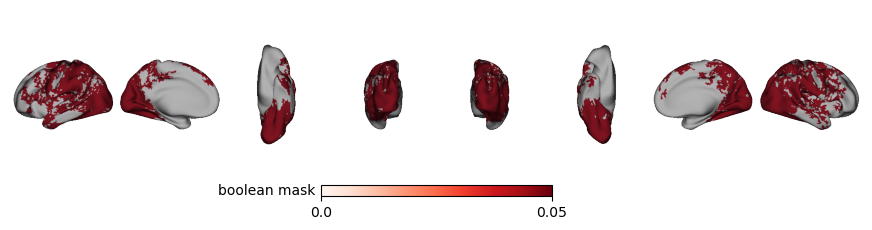

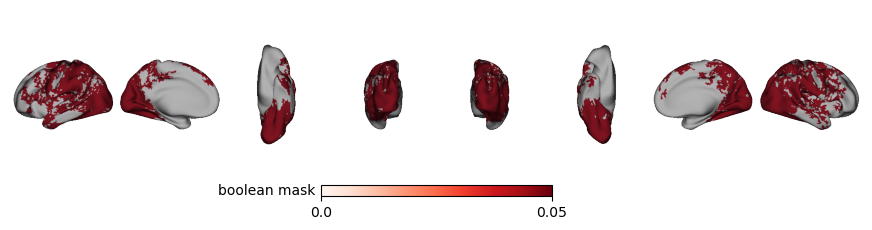

In [82]:
fsaverage_to_fslr_and_plot("/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_L.gii", 
                           "/Volumes/life-encoding/results/himalaya/glove_variancepartition/mask_nonmedial_fullr_R.gii", f'boolean mask', cmap = 'Reds')

## without moten

In [76]:
import numpy as np

array_dict_L = {
    'f1_ac_L': f1_ac_L,
    'f1_ag_L': f1_ag_L,
    'f1_bg_L': f1_bg_L,
    'f1_mo_L': f1_mo_L,
    'f2_acag_L': f2_acag_L,
    'f2_acbg_L': f2_acbg_L,
    'f2_acmo_L': f2_acmo_L,
    'f2_agbg_L': f2_agbg_L,
    'f2_agmo_L': f2_agmo_L,
    'f2_bgmo_L': f2_bgmo_L,
    'f3_acagbg_L': f3_acagbg_L,
    'f3_acagmo_L': f3_acagmo_L,
    'f3_acbgmo_L': f3_acbgmo_L,
    'f3_agbgmo_L': f3_agbgmo_L,
    'f4_acagbgmo_L': f4_acagbgmo_L
}

array_dict_R = {
    'f1_ac_R': f1_ac_R,
    'f1_ag_R': f1_ag_R,
    'f1_bg_R': f1_bg_R,
    'f1_mo_R': f1_mo_R,
    'f2_acag_R': f2_acag_R,
    'f2_acbg_R': f2_acbg_R,
    'f2_acmo_R': f2_acmo_R,
    'f2_agbg_R': f2_agbg_R,
    'f2_agmo_R': f2_agmo_R,
    'f2_bgmo_R': f2_bgmo_R,
    'f3_acagbg_R': f3_acagbg_R,
    'f3_acagmo_R': f3_acagmo_R,
    'f3_acbgmo_R': f3_acbgmo_R,
    'f3_agbgmo_R': f3_agbgmo_R,
    'f4_acagbgmo_R': f4_acagbgmo_R
}

combination_listL_subset = ['f1_ac_L', 'f1_ag_L', 'f1_bg_L', 'f2_acag_L', 'f2_acbg_L', 'f2_agbg_L', 'f3_acagbg_L' ]
combination_listR_subset = ['f1_ac_R', 'f1_ag_R', 'f1_bg_R',  'f2_acag_R', 'f2_acbg_R', 'f2_agbg_R', 'f3_acagbg_R']

# argmax stacked values
stacked_L = np.stack([array_dict_L[l] for l in combination_listL_subset], axis=0) # Stack the arrays
argmax_indices_L_subset = np.argmax(stacked_L, axis=0)  # Perform argmax column-wise 

stacked_R = np.stack([array_dict_R[l] for l in combination_listR_subset], axis=0) # Stack the arrays
argmax_indices_R_subset = np.argmax(stacked_R, axis=0) # Perform argmax column-wise 


In [112]:
f3_agbgmo_R.dtype
[l for l in combination_listL_subset]

['f1_ac_L',
 'f1_ag_L',
 'f1_bg_L',
 'f2_acag_L',
 'f2_acbg_L',
 'f2_agbg_L',
 'f3_acagbg_L']

In [107]:

print(f"min: {np.min(f3_acbgmo_R)}, max: {np.max(f3_acbgmo_R)}")

min: -0.31199389696121216, max: 0.3189322054386139


In [103]:
print(f"min: {np.min(stacked_L)}, max: {np.max(stacked_L)}")

min: -1.0106453895568848, max: 1.0217106342315674


In [70]:
# fullgifti_L = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-lh_ttest_cluster-100.gii').agg_data()
# fullgifti_R = nib.load('/Volumes/life-encoding/results/himalaya/glove_variancepartition/full-r_acagbgmo_pca-40_align-ha_common_hemi-rh_ttest_cluster-100.gii').agg_data()
# main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
# main_dir = '/Volumes/life-encoding'
# medial_mask_L = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_lh.npy'))
# medial_mask_R = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_rh.npy'))
argmax_masked_L_subset = ~medial_mask_L * fullgifti_L.astype(bool) * (argmax_indices_L_subset + 1)
argmax_masked_R_subset = ~medial_mask_R * fullgifti_R.astype(bool) * (argmax_indices_R_subset + 1)

In [78]:
print(f"unique values of L hemi: {np.unique(argmax_masked_L_subset, return_counts=True)}")
print(f"unique values of R hemi: {np.unique(argmax_masked_R_subset, return_counts=True)}")
print(combination_listL_subset)

print(f"unique values of L hemi: {np.unique(argmax_masked_L, return_counts=True)}")
print(combination_listL)

unique values of L hemi: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([21768,  1187,   446,   527,   872,   188, 12893,  3081]))
unique values of R hemi: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([21125,  1133,   434,   568,   943,   257, 13078,  3424]))
['f1_ac_L', 'f1_ag_L', 'f1_bg_L', 'f2_acag_L', 'f2_acbg_L', 'f2_agbg_L', 'f3_acagbg_L']
unique values of L hemi: (array([ 0,  1,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 15]), array([21768,    60,     1,     2,    11,    47,     8,  2034,  1515,
       13774,   714,   659,   369]))
['f1_ac_L', 'f1_ag_L', 'f1_bg_L', 'f1_mo_L', 'f2_acag_L', 'f2_acbg_L', 'f2_acmo_L', 'f2_agbg_L', 'f2_agmo_L', 'f2_bgmo_L', 'f3_acagbg_L', 'f3_acagmo_L', 'f3_acbgmo_L', 'f3_agbgmo_L', 'f4_acagbgmo_L']


## plot  argmax_masked_L_subset agbg

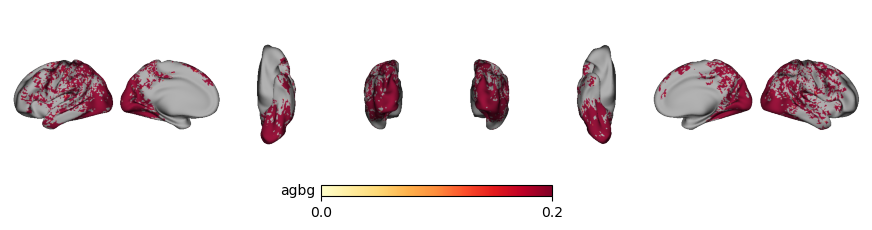

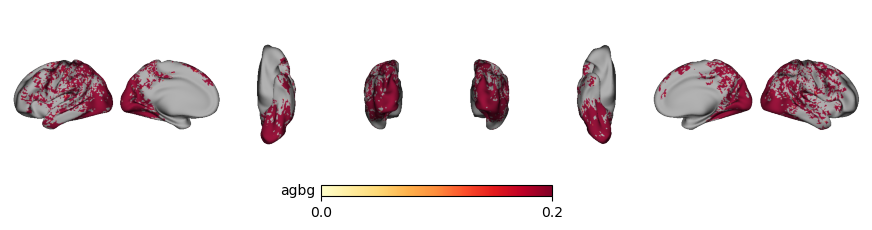

In [100]:
masked_agbg_L = (argmax_masked_L_subset == 6)
write_gifti_v2(masked_agbg_L.astype(np.float32), 
    output_fn=f"{gii_dir}/TST_masked_agbg.lh.gii",
    template_fn = os.path.join(suma_dir, f"lh.pial.gii"))

masked_agbg_R = (argmax_masked_R_subset == 6)
write_gifti_v2(masked_agbg_R.astype(np.float32), 
    output_fn=f"{gii_dir}/TST_masked_agbg.rh.gii",
    template_fn = os.path.join(suma_dir, f"rh.pial.gii"))

fsaverage_to_fslr_and_plot(join(gii_dir, "TST_masked_agbg.lh.gii"), 
                           join(gii_dir, "TST_masked_agbg.rh.gii"), f'agbg', cmap = 'YlOrRd', min=0, max=.2)

## calculate argmax

In [340]:
# palette = {
#     'f1_ac_L': '#941100',
#     'f1_ag_L': '#008F51',
#     'f1_bg_L': '#011891',
#     'f1_mo_L': '#808285',
#     'f2_acag_L': '#FFCC00',
#     'f2_acbg_L': '#ff3399',
#     'f2_acmo_L': '#000000',
#     'f2_agbg_L': '#02CDFF',
#     'f2_agmo_L': '#000000',
#     'f2_bgmo_L': '#000000',
#     'f3_acagbg_L': '#ffffff',
#     'f3_acagmo_L': '#000000',
#     'f3_acbgmo_L': '#000000',
#     'f3_agbgmo_L': '#000000',
#     'f4_acagbgmo_L': '#000000',
    

# }

# palette_R =    { 'f1_ac_R': '#941100',
#     'f1_ag_R': '#008F51',
#     'f1_bg_R': '#011891',
#     'f1_mo_R': '#808285',
#     'f2_acag_R': '#FFCC00',
#     'f2_acbg_R': '#ff3399',
#     'f2_acmo_R': '#000000',
#     'f2_agbg_R': '#02CDFF',
#     'f2_agmo_R': '#000000',
#     'f2_bgmo_R': '#000000',
#     'f3_acagbg_R': '#ffffff',
#     'f3_acagmo_R': '#000000',
#     'f3_acbgmo_R': '#000000',
#     'f3_agbgmo_R': '#000000',
#     'f4_acagbgmo_R':'#000000'}

# # Mapping categories to numeric values (ignoring np.nan)
# categories = {key: i+1 for i, key in enumerate(palette.keys())}
# categories_R = {key: i+1 for i, key in enumerate(palette_R.keys())}

# numeric_result_L = np.array([categories[key] for key in result_keys_L if key in categories])
# numeric_result_R = np.array([categories_R[key] for key in result_keys_R if key in categories_R])

# # Verify numeric_result matches length (40962)
# assert len(numeric_result_L) == 40962, "Length of numeric_result must be 40962!"
# assert len(numeric_result_R) == 40962, "Length of numeric_result must be 40962!"
# write_gifti_v2(numeric_result_L.astype(np.int32)*maskL,
#         template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
#         output_fn = join('/Users/h/Desktop', "TST_argmax.lh.gii"))
# write_gifti_v2(numeric_result_R.astype(np.int32)*maskR,
#         template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
#         output_fn = join('/Users/h/Desktop', "TST_argmax.rh.gii"))


# # Create a new GIFTI data array using the original integer data
# new_gii_data_array = nib.gifti.GiftiDataArray(numeric_result_L.astype(np.int32))
# new_gii_img = nib.gifti.GiftiImage(darrays=[new_gii_data_array])
# nib.save(new_gii_img, join('/Users/h/Desktop', 'labeled_data_lh.gii'))

# new_gii_data_array = nib.gifti.GiftiDataArray(numeric_result_R.astype(np.int32))
# new_gii_img = nib.gifti.GiftiImage(darrays=[new_gii_data_array])
# nib.save(new_gii_img, join('/Users/h/Desktop', 'labeled_data_rh.gii'))


In [316]:
numeric_result_L
numeric_result_R

print(f"min: {np.min(numeric_result_L)}")
print(f"min: {np.min(numeric_result_R)}")
print(f"max: {np.max(numeric_result_L)}")
print(f"max: {np.max(numeric_result_R)}")

min: 1
min: 1
max: 15
max: 15


In [282]:
TST = nib.load(join('/Users/h/Desktop', "TST_argmax.rh.gii"))
TST.agg_data()

array([ 0, 11,  0, ..., 11,  0,  0], dtype=int32)

In [283]:
np.max(TST.agg_data())

15

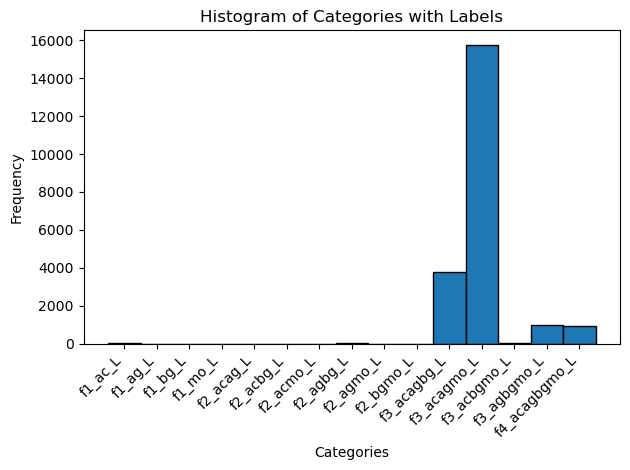

In [317]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming giiL.agg_data() contains the numeric data from 0 to 14
data = giiL.agg_data()

# Palette with labels corresponding to numbers 1-14
palette = {
    1: 'f1_ac_L',
    2: 'f1_ag_L',
    3: 'f1_bg_L',
    4: 'f1_mo_L',
    5: 'f2_acag_L', # yellow
    6: 'f2_acbg_L', # pink
    7: 'f2_acmo_L', #red + gray
    8: 'f2_agbg_L', # # cyan + 
    9: 'f2_agmo_L', # green + gray
    10: 'f2_bgmo_L', # blue + gray
    11: 'f3_acagbg_L', # white
    12: 'f3_acagmo_L',
    13: 'f3_acbgmo_L', # pink + gray
    14: 'f3_agbgmo_L', #cyan + gray
    15: 'f4_acagbgmo_L' # white
}


# Create the histogram
plt.hist(data, bins=np.arange(0.5, 16.5, 1), edgecolor='black')

# Set the tick marks to correspond to the categories
plt.xticks(ticks=np.arange(1, 16), labels=[palette[i] for i in range(1, 16)], rotation=45, ha="right")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Histogram of Categories with Labels")

# Display the plot
plt.tight_layout()
plt.show()


In [313]:
data

array([ 0, 12,  0, ..., 12,  0,  0], dtype=int32)

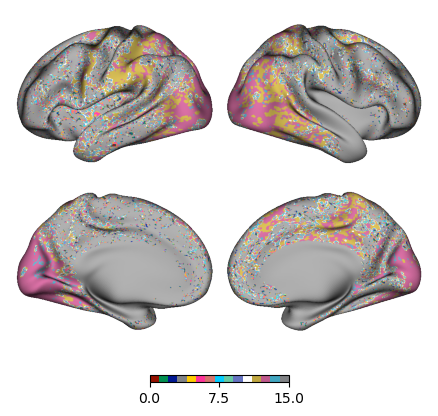

In [368]:
import numpy as np
import nibabel as nib
from os.path import join
from neuromaps.datasets import fetch_fslr
from neuromaps.transforms import fsaverage_to_fslr
from surfplot import Plot
from matplotlib.colors import ListedColormap

# NOTE 1: Define the palette (shared across left and right hemispheres)
palette = {
    '1': '#941100', # red
    '2': '#008F51', # green
    '3': '#011891', # blue
    '4': '#808285', # gray
    '5': '#FFCC00', #yellow
    '6': '#ff3399', #pink
    '7': '#D4746D', #red + gray
    '8': '#02CDFF', # cyan
    '9':'#66C9A3', # green + gray
    '10': '#6573C1',# blue + gray
    '11': '#ffffff',# white
    '12': '#BFA640',# yello gray
    '13': '#BF598C',# pink + gray
    '14': '#41A6C0',# cyan + gray
    '15': '#808285',# white
}
# NOTE 2: Load the fsLR surfaces for plotting
surfaces_fslr = fetch_fslr()
lh_fslr, rh_fslr = surfaces_fslr['inflated']

# NOTE 3: Load the GIFTI files and convert to fsLR
giiL = nib.load(join('/Users/h/Desktop', "TST_argmax.lh.gii"))
giiR = nib.load(join('/Users/h/Desktop', "TST_argmax.rh.gii"))

cmap = ListedColormap(palette.values())

# TODO: ISSUE. fsaverage_to_fslr transformation turns the integers into values...
# resampling creates an issue - we may have to create separate gifti files per combination (acbgmo, acbg, etc)
# and transform them one by one.
L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')

# NOTE 4: Plot the data
p = Plot(lh_fslr, rh_fslr)
p.add_layer({'left': L_fslr[0], 'right': R_fslr[0]}, cmap=cmap, cbar=True) #, color_range=(1,20))

p.build()
plt.show()


## printing out dimensions

In [365]:
L_fslr.agg_data()

array([0, 9, 3, ..., 1, 6, 0], dtype=int32)

In [322]:
giiL.agg_data().shape
np.round(L_fslr[0].agg_data()).shape

(32492,)

In [319]:
giiL.agg_data()

array([ 0, 12,  0, ..., 12,  0,  0], dtype=int32)

In [306]:
np.round(L_fslr[0].agg_data())

array([0., 9., 4., ..., 2., 7., 0.], dtype=float32)

In [358]:
L_fslr[0].agg_data().astype(np.int32)

array([0, 9, 3, ..., 1, 6, 0], dtype=int32)

In [359]:
L_fslr[0].agg_data()

array([0.       , 9.409448 , 3.533145 , ..., 1.6859269, 6.525036 ,
       0.       ], dtype=float32)

In [369]:
# Define left hemisphere palette
palette_lh = {
    'f1_ac_L': '#941100',
    'f1_ag_L': '#008F51',
    'f1_bg_L': '#011891',
    'f1_mo_L': '#808285',
    'f2_acag_L': '#FFCC00',
    'f2_acbg_L': '#ff3399',
    'f2_acmo_L': np.nan,
    'f2_agbg_L': '#02CDFF',
    'f2_agmo_L': np.nan,
    'f2_bgmo_L': np.nan,
    'f3_acagbg_L': '#ffffff',
    'f3_acbgmo_L': np.nan,
    'f3_agbgmo_L': np.nan,
    'f4_acagbgmo_L': np.nan
}

# Define right hemisphere palette
palette_rh = {
    'f1_ac_R': '#d73027',
    'f1_ag_R': '#1a9850',
    'f1_bg_R': '#4575b4',
    'f1_mo_R': '#d3d3d3',
    'f2_acag_R': '#fee08b',
    'f2_acbg_R': '#fdae61',
    'f2_acmo_R': np.nan,
    'f2_agbg_R': '#91bfdb',
    'f2_agmo_R': np.nan,
    'f2_bgmo_R': np.nan,
    'f3_acagbg_R': '#f7f7f7',
    'f3_acagmo_R': np.nan,
    'f3_acbgmo_R': np.nan,
    'f3_agbgmo_R': np.nan,
    'f4_acagbgmo_R': np.nan
}

# Map categories to numeric values, ignoring NaNs
categories_lh = {key: i+1 for i, key in enumerate(palette_lh.keys()) if isinstance(palette_lh[key], str)}
categories_rh = {key: i+1 for i, key in enumerate(palette_rh.keys()) if isinstance(palette_rh[key], str)}

# Function to print out the mapping
def print_palette_mapping(categories, palette, hemisphere):
    print(f"\nMapping for {hemisphere} Hemisphere:")
    print(f"{'Numeric Value':<15}{'Key':<20}{'Color'}")
    print("-" * 50)
    for key, num in categories.items():
        color = palette[key]
        print(f"{num:<15}{key:<20}{color}")

# Print out the mappings for both hemispheres
print_palette_mapping(categories_lh, palette_lh, 'Left')
print_palette_mapping(categories_rh, palette_rh, 'Right')



Mapping for Left Hemisphere:
Numeric Value  Key                 Color
--------------------------------------------------
1              f1_ac_L             #941100
2              f1_ag_L             #008F51
3              f1_bg_L             #011891
4              f1_mo_L             #808285
5              f2_acag_L           #FFCC00
6              f2_acbg_L           #ff3399
8              f2_agbg_L           #02CDFF
11             f3_acagbg_L         #ffffff

Mapping for Right Hemisphere:
Numeric Value  Key                 Color
--------------------------------------------------
1              f1_ac_R             #d73027
2              f1_ag_R             #1a9850
3              f1_bg_R             #4575b4
4              f1_mo_R             #d3d3d3
5              f2_acag_R           #fee08b
6              f2_acbg_R           #fdae61
8              f2_agbg_R           #91bfdb
11             f3_acagbg_R         #f7f7f7


## confirming that the unique and combinatoric variance looks good and similar to previous maps

In [88]:
print(np.max(nib.load(f2_agbg_L_fname).agg_data()))
print(np.max(nib.load(f1_ac_L_fname).agg_data()))

0.22271633
0.23671737


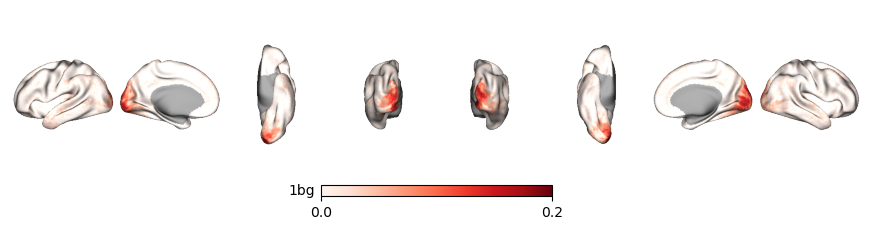

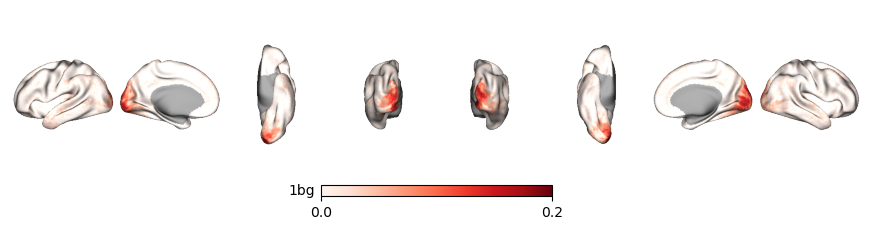

In [118]:
fsaverage_to_fslr_and_plot(f1_mo_L_fname, f1_mo_R_fname, f'1mo', cmap = 'Reds', min=0, max=.2)

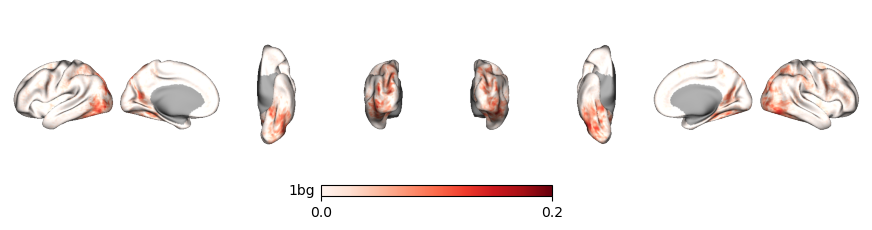

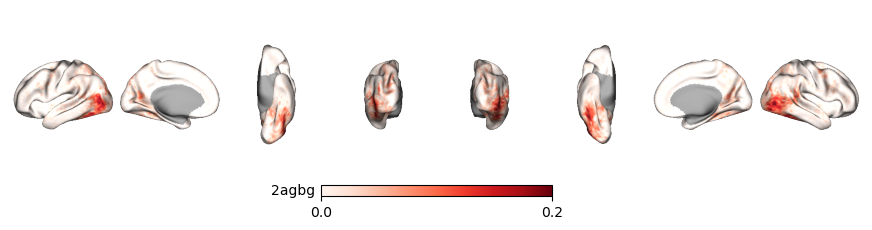

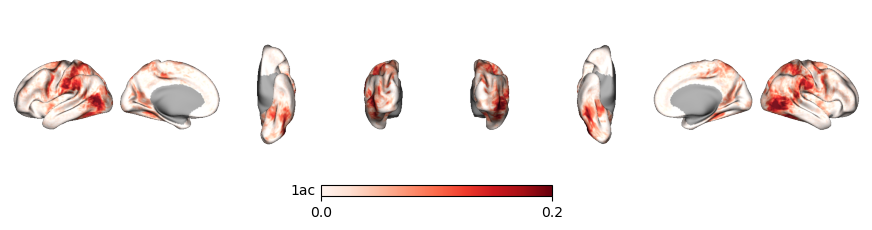

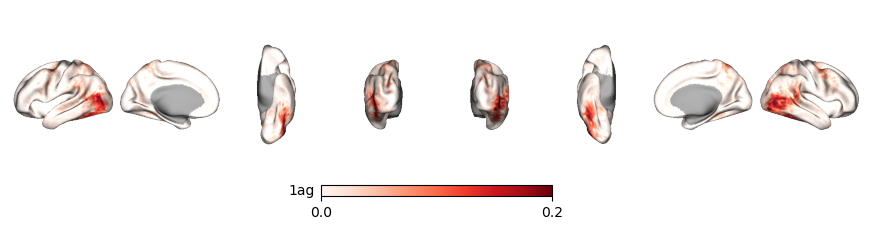

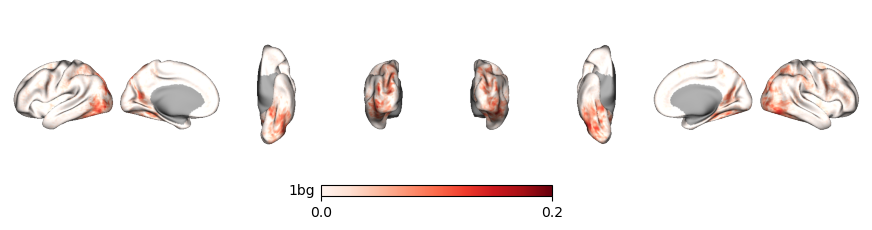

In [117]:
fsaverage_to_fslr_and_plot(f2_agbg_L_fname, f2_agbg_R_fname, f'2agbg', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_ac_L_fname, f1_ac_R_fname, f'1ac', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_ag_L_fname, f1_ag_R_fname, f'1ag', cmap = 'Reds', min=0, max=.2)
fsaverage_to_fslr_and_plot(f1_bg_L_fname, f1_bg_R_fname, f'1bg', cmap = 'Reds', min=0, max=.2)

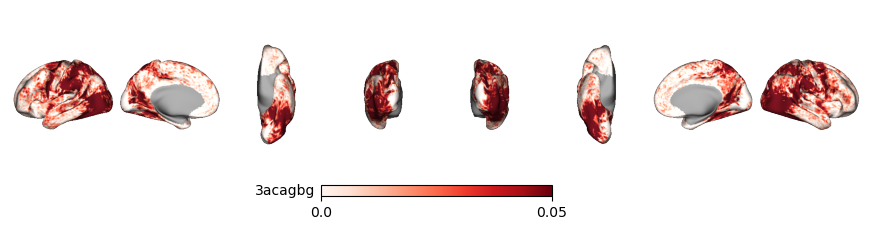

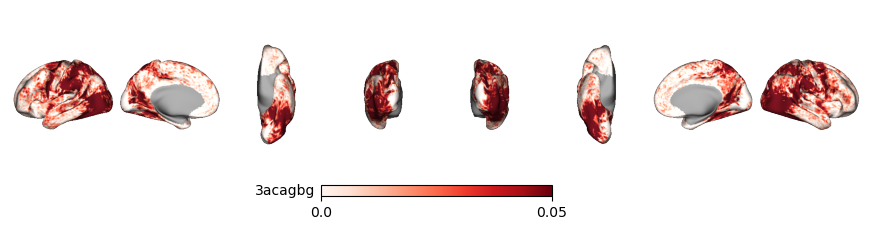

In [117]:
fsaverage_to_fslr_and_plot(f3_acagbg_L_fname, f3_acagbg_R_fname, f'3acagbg', cmap = 'Reds')

In [129]:
write_gifti_v2(f1_ac_L.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
        output_fn = join(save_dir, "TST_actions.lh.gii"))
write_gifti_v2(f1_ac_R.astype(np.float32),
        template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
        output_fn = join(save_dir, "TST_actions.rh.gii"))
print(f"max value: {np.max(nib.load(join(save_dir, "TST_actions.lh.gii")).agg_data())}")
fsaverage_to_fslr_and_plot(join(save_dir, "TST_actions.lh.gii"), 
                           join(save_dir, "TST_actions.rh.gii"), f'unique_actions', cmap = 'YlOrRd')

In [130]:
np.max(nib.load(join(save_dir, "TST_actions.lh.gii")).agg_data())

0.12688039

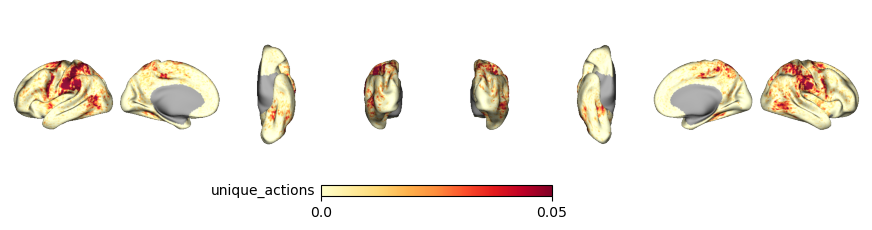

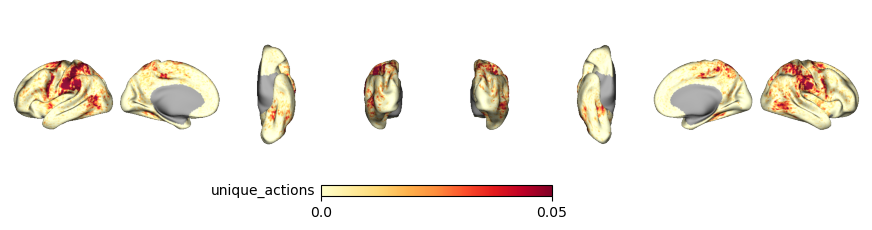

In [132]:
fsaverage_to_fslr_and_plot(join(save_dir, "TST_actions.lh.gii"), 
                           join(save_dir, "TST_actions.rh.gii"), f'unique_actions', cmap = 'YlOrRd')

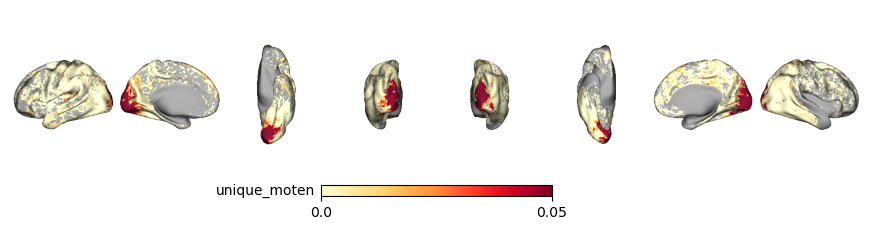

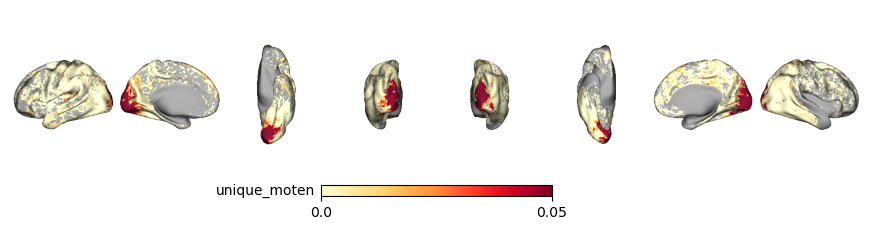

In [136]:
write_gifti_v2(f1_mo_L.astype(np.float32)*maskL,
        template_fn = os.path.join(suma_dir, f"lh.pial.gii"), 
        output_fn = join(save_dir, "TST_moten.lh.gii"))
write_gifti_v2(f1_mo_R.astype(np.float32)*maskR,
        template_fn = os.path.join(suma_dir, f"rh.pial.gii"), 
        output_fn = join(save_dir, "TST_moten.rh.gii"))
# print(f"max value: {np.max(nib.load(join(save_dir, "TST_moten.lh.gii")).agg_data()) }")
fsaverage_to_fslr_and_plot(join(save_dir, "TST_moten.lh.gii"), 
                           join(save_dir, "TST_moten.rh.gii"), f'unique_moten', cmap = 'YlOrRd')